## Imports

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os


In [93]:
DATA_DIR = "data/"

train_df = pd.read_csv(os.path.join(DATA_DIR,"train.csv"),index_col=0)

test_df_missing_target  = pd.read_csv(os.path.join(DATA_DIR,"test.csv"),index_col=0)
target_test_df          = pd.read_csv(os.path.join(DATA_DIR,"gender_submission.csv"),index_col=0)
test_df = pd.merge(  test_df_missing_target
                   , target_test_df
                   , left_index=True
                   , right_index=True
                   , how='left'
                   , suffixes=('', '_target')).copy()


## Data Exploration

In [62]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: xlabel='Age', ylabel='Count'>

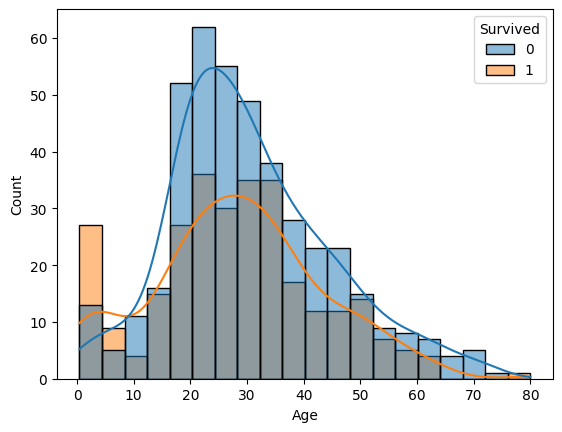

In [63]:
sns.histplot(data=train_df, x='Age', kde=True, hue='Survived')

<Axes: xlabel='Sex', ylabel='Count'>

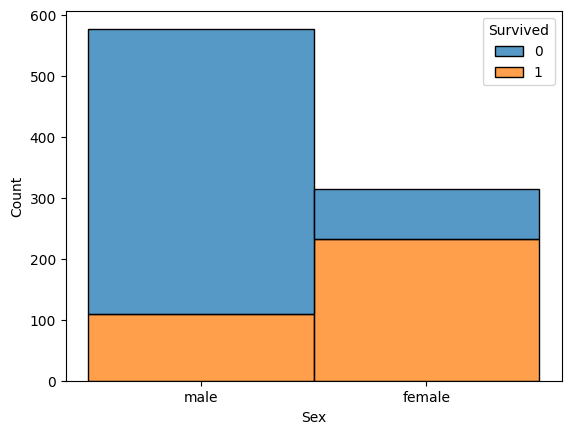

In [64]:
sns.histplot(data=train_df,x="Sex", hue="Survived", multiple="stack")

<Axes: xlabel='Age', ylabel='Fare'>

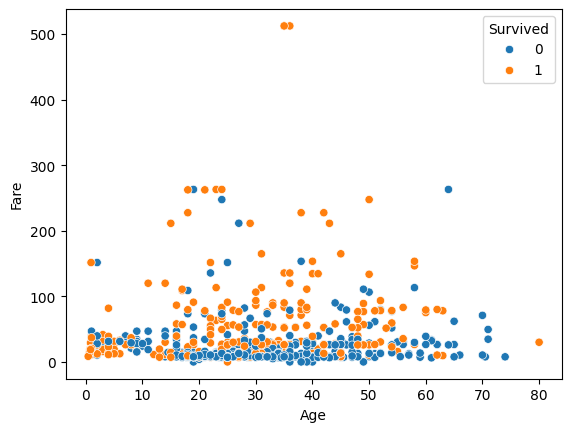

In [65]:
sns.scatterplot(data=train_df, x='Age', y='Fare', hue='Survived')

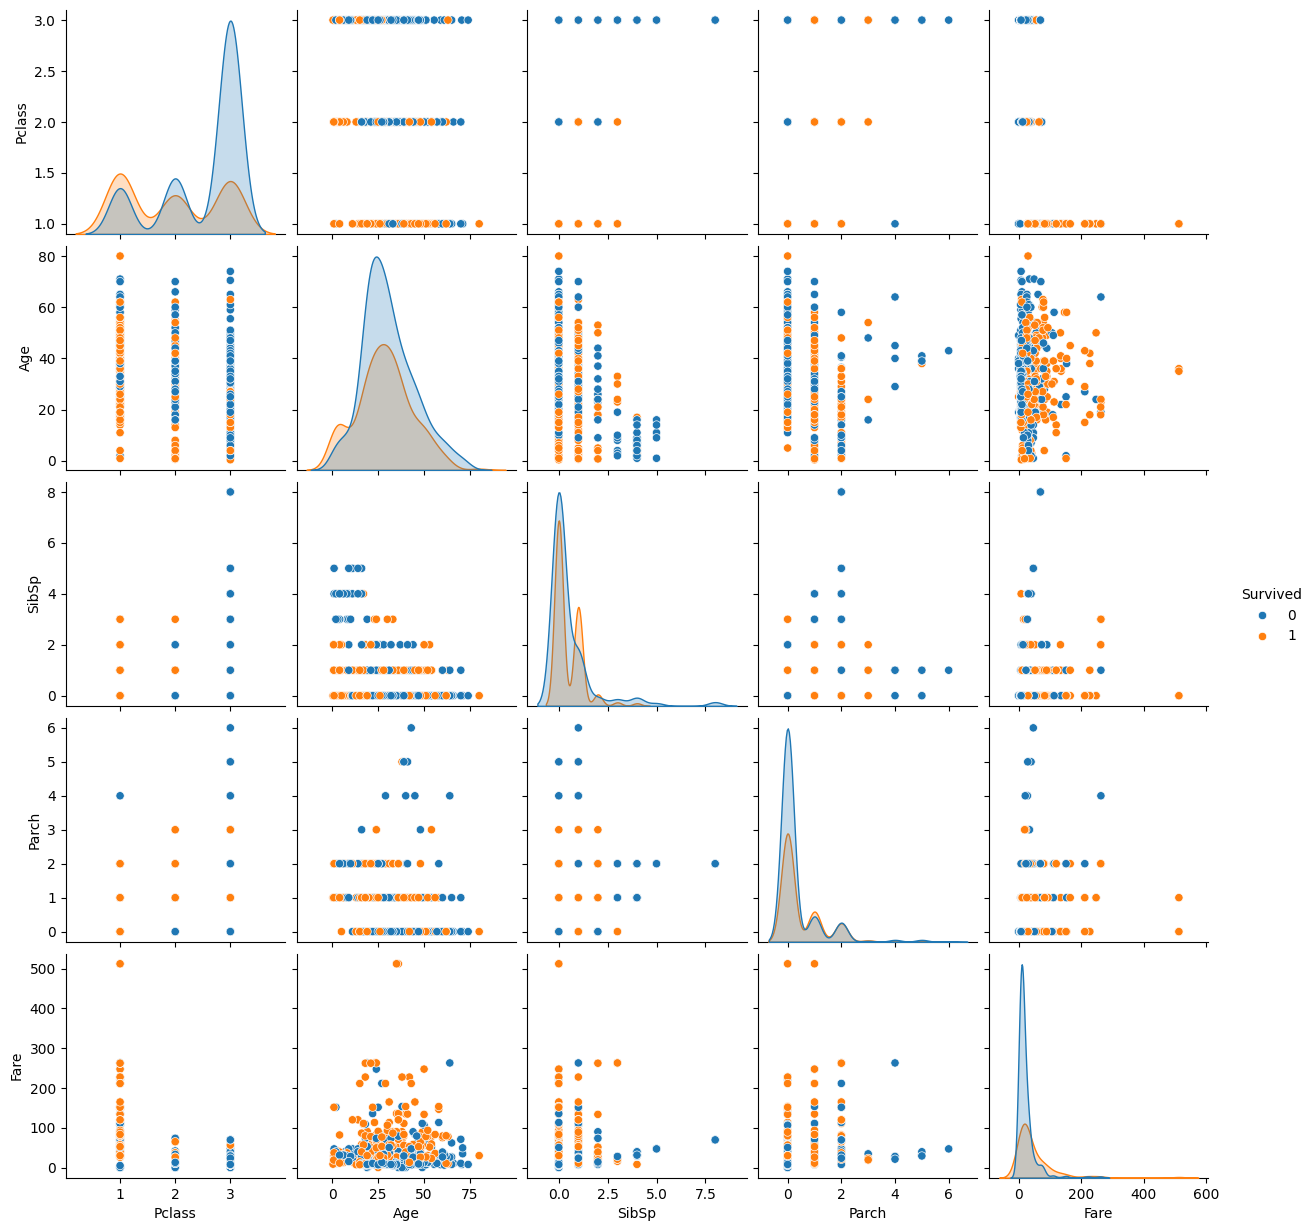

In [66]:
sns.pairplot(train_df, hue='Survived')

## Data Cleaning

In [67]:
train_df.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)
test_df.drop(columns=['Name', 'Ticket', 'Cabin'], inplace=True)

train_df.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

<Axes: xlabel='Age', ylabel='Count'>

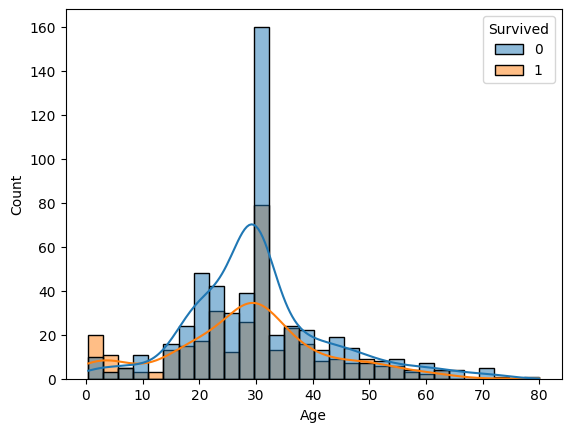

In [68]:
# Replacing missing values with scikit-learn's SimpleImputer
from sklearn.impute import SimpleImputer
# We have missing values in Age and Embarked columns
imputer = SimpleImputer().set_output(transform="pandas")
imputer.fit(train_df[['Age']])
train_df[['Age']] = imputer.transform(train_df[['Age']])
test_df[['Age']] = imputer.transform(test_df[['Age']])
train_df.isna().sum()
sns.histplot(data=train_df, x='Age', kde=True, hue='Survived')

In [69]:
train_df["Embarked"].fillna("S", inplace=True)
test_df["Embarked"].fillna("S", inplace=True)
test_df.dropna(subset=['Fare'], inplace=True)
train_df.isna().sum()

/var/folders/0h/1kd8l6fj7vgcphlm30qlmcxc0000gp/T/ipykernel_63365/2300660040.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df["Embarked"].fillna("S", inplace=True)
/var/folders/0h/1kd8l6fj7vgcphlm30qlmcxc0000gp/T/ipykernel_63365/2300660040.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## Data Preparation

### NUMERICAL FEATURES

In [70]:
from sklearn.preprocessing import StandardScaler

numeric_features = ['Age', 'Fare']

scaler = StandardScaler()
train_df_scaled = train_df.copy()
train_df_scaled[numeric_features] = scaler.fit_transform(train_df[numeric_features])

test_df_scaled = test_df.copy()
test_df_scaled[numeric_features] = scaler.transform(test_df[numeric_features])
test_df_scaled.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived
PassengerId,,,,,,,,
892,3,male,0.369449,0,0,-0.490783,Q,0
893,3,female,1.331378,1,0,-0.507479,S,1
894,2,male,2.485693,0,0,-0.453367,Q,0
895,3,male,-0.207709,0,0,-0.474005,S,0
896,3,female,-0.592481,1,1,-0.401017,S,1


### Categorical Features

In [71]:
from sklearn.preprocessing import OneHotEncoder

categorical_features =  ["Sex", "Embarked"]
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first').set_output(transform="pandas")
train_df_encoded = encoder.fit_transform(train_df[categorical_features])
test_df_encoded = encoder.transform(test_df[categorical_features])


train_df_final = pd.concat([train_df_scaled, train_df_encoded], axis=1).drop(columns=['Sex', 'Embarked'])
test_df_final = pd.concat([test_df_scaled, test_df_encoded], axis=1).drop(columns=["Sex", "Embarked"])
train_df_final.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
1,0,3,-0.592481,1,0,-0.502445,1.0,0.0,1.0
2,1,1,0.638789,1,0,0.786845,0.0,0.0,0.0
3,1,3,-0.284663,0,0,-0.488854,0.0,0.0,1.0
4,1,1,0.407926,1,0,0.420730,0.0,0.0,1.0
5,0,3,0.407926,0,0,-0.486337,1.0,0.0,1.0


In [72]:

test_df_final.head()

,Pclass,Age,SibSp,Parch,Fare,Survived,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
892,3,0.369449,0,0,-0.490783,0,1.0,1.0,0.0
893,3,1.331378,1,0,-0.507479,1,0.0,0.0,1.0
894,2,2.485693,0,0,-0.453367,0,1.0,1.0,0.0
895,3,-0.207709,0,0,-0.474005,0,1.0,0.0,1.0
896,3,-0.592481,1,1,-0.401017,1,0.0,0.0,1.0


In [73]:
X_train = train_df_final.drop(columns=['Survived'])
y_train = train_df_final['Survived']
X_test = test_df_final.drop(columns=['Survived'])
y_test = test_df_final['Survived']

## Model Training

### Logistic Regression

In [74]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((891, 8), (891,), (417, 8), (417,))

In [75]:
from sklearn.linear_model import LogisticRegression

lin = LogisticRegression(max_iter=1000, random_state=42)
lin.fit(X_train, y_train)
lin.score(X_test, y_test)

0.9424460431654677

### Random Forest Classifier

In [76]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)


0.8129496402877698

### FInetuning | Hyperparameter Tuning | Grid Search

In [81]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(lin, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_, "Best score:", grid_search.best_score_)
best_lin = grid_search.best_estimator_
best_lin.score(X_test, y_test)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'} Best score: 0.7935032326909799


0.9544364508393285

In [87]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

classification_report_lin = classification_report(y_test, best_lin.predict(X_test))
print("Random Forest Classification Report:\n", classification_report_lin)

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       265
           1       0.93      0.94      0.94       152

    accuracy                           0.95       417
   macro avg       0.95      0.95      0.95       417
weighted avg       0.95      0.95      0.95       417



## Saving the Model & Processors 

In [88]:
import pickle, os

if not os.path.exists("models"):
    os.makedirs("models")

with open("models/best_logistic_model.pkl", "wb") as f:
    pickle.dump(best_lin, f)

with open("models/preprocessor_numeric.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("models/preprocessor_categorical.pkl", "wb") as f:
    pickle.dump(encoder, f)


In [96]:
type(train_df) , train_df.shape

(pandas.core.frame.DataFrame, (891, 11))

In [97]:
type(train_df["Age"]) , train_df["Age"].shape

(pandas.core.series.Series, (891,))

#